<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/signal_kalman_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [ ]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ticker = pd.read_csv('/content/ind_nifty50list.csv')
START = "2013-01-01"

In [ ]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [ ]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

In [ ]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [ ]:
df_kalman = pd.DataFrame(nlst).T

In [ ]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [ ]:
df_kalman

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,kalman_16,kalman_17,kalman_18,kalman_19,kalman_20,kalman_21,kalman_22,kalman_23,kalman_24,kalman_25,kalman_26,kalman_27,kalman_28,kalman_29,kalman_30,kalman_31,kalman_32,kalman_33,kalman_34,kalman_35,kalman_36,kalman_37,kalman_38,kalman_39,kalman_40,kalman_41,kalman_42,kalman_43,kalman_44,kalman_45,kalman_46,kalman_47,kalman_48,kalman_49,kalman_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,65.835472,206.728653,129.232437,847.128052,64.018013,452.160980,36.689011,140.882996,112.068314,200.913635,92.239120,250.725891,853.046814,128.392365,233.326309,66.434975,161.460968,NaN,739.455994,62.683018,228.562958,364.283997,93.695145,77.444077,21.395088,202.735535,115.882721,35.877300,161.610428,310.641113,220.527756,699.112610,44.348415,2206.362549,64.005463,31.944605,194.526489,NaN,2223.067627,112.237495,176.291870,264.349396,70.842010,154.909637,169.012375,97.388908,135.607086,39.866035,981.731323,68.523903
2013-01-02,44.301434,134.625679,89.202722,601.984038,41.738011,300.527877,25.851172,93.303391,75.586402,135.858537,61.061613,169.437516,569.868055,81.624553,154.859885,44.728346,108.529772,NaN,497.094668,42.315429,152.307717,250.798873,64.136044,50.960978,14.834763,141.374568,77.273393,23.697896,110.037108,213.363217,146.009685,492.509850,30.324117,1484.294764,44.883289,21.014416,131.912247,NaN,1468.345958,76.306258,117.965077,175.984138,50.661000,104.081257,112.641711,65.762985,90.965839,26.294578,662.499860,44.954477
2013-01-03,33.114971,102.693333,67.335757,458.978498,33.856766,228.793364,19.355406,74.529299,57.823575,100.005986,46.463860,122.921167,458.438933,61.534587,114.431490,33.654766,79.973398,NaN,362.609936,31.312632,115.413643,187.357331,47.860287,37.468506,11.070711,106.953337,60.109223,18.017535,81.773047,156.363460,108.722827,359.579518,22.762017,1062.910493,35.523937,16.200971,103.365607,NaN,1116.945597,58.683843,85.943501,137.399732,37.463009,78.125859,86.872843,49.575036,64.636979,22.021992,489.250574,34.760931
2013-01-04,25.876689,82.538988,52.191897,361.217827,27.130234,195.465481,16.758738,58.915043,47.146152,78.684323,38.538950,104.385446,371.938625,46.581963,93.001947,28.303571,62.459994,NaN,290.045894,23.663575,93.936972,144.406772,39.621841,29.474450,10.087534,82.829982,49.015867,14.166759,63.539351,122.366044,88.782381,289.209962,18.822906,833.560660,30.327862,13.318013,83.087665,NaN,882.819102,48.057660,69.240587,116.125947,28.767909,60.379188,64.058371,39.846170,53.743709,17.181514,404.581838,29.420471
2013-01-07,23.590162,68.174339,42.521468,295.199702,22.444271,151.866254,15.936376,48.941263,36.152465,72.134842,30.572814,81.037516,308.537936,40.330120,76.898208,22.487775,47.657974,NaN,247.733628,21.156567,71.591137,109.568016,32.978556,23.052613,8.418146,69.491502,42.950985,13.763725,52.214863,89.258342,79.005481,271.081685,15.065126,693.246905,26.543835,10.839168,67.202988,NaN,684.396077,38.568623,61.265410,95.238470,22.941144,48.554805,58.128416,30.513683,41.785358,14.992721,336.120272,24.886649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29,14.998207,238.879274,14.557828,6.905575,1212.480154,4469.126562,3.587136,90.929440,17.446414,19.076014,16.567901,763.761173,-182.006960,-116.768444,311.919667,109.697480,94.504919,-2.533636,-221.391882,71.411381,-38.861704,275.649976,159.131570,11.202589,21.707402,135.684463,187.642095,66.539057,215.408571,250.797914,107.484054,408.700883,20.199755,958.327296,30.204989,17.373483,329.400521,97.143924,1318.500866,103.180028,96.330355,108.335843,86.843362,171.742530,215.166343,305.640073,591.044237,49.555821,889.873649,101.106176
2021-11-01,26.135565,257.986429,24.659968,25.548709,1214.029011,4171.748793,7.462123,116.904559,19.648843,23.0

In [ ]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=12, adjust=False).mean()-df[var].ewm(span=26, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=9,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [ ]:
final_kalman=macd_calc(df_kalman)

In [ ]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,kalman_16,kalman_17,kalman_18,kalman_19,kalman_20,kalman_21,kalman_22,kalman_23,kalman_24,kalman_25,kalman_26,kalman_27,kalman_28,kalman_29,kalman_30,kalman_31,kalman_32,kalman_33,kalman_34,kalman_35,kalman_36,kalman_37,kalman_38,kalman_39,kalman_40,...,histkalman_37,macdkalman_38,macdsignalkalman_38,histkalman_38,macdkalman_39,macdsignalkalman_39,histkalman_39,macdkalman_40,macdsignalkalman_40,histkalman_40,macdkalman_41,macdsignalkalman_41,histkalman_41,macdkalman_42,macdsignalkalman_42,histkalman_42,macdkalman_43,macdsignalkalman_43,histkalman_43,macdkalman_44,macdsignalkalman_44,histkalman_44,macdkalman_45,macdsignalkalman_45,histkalman_45,macdkalman_46,macdsignalkalman_46,histkalman_46,macdkalman_47,macdsignalkalman_47,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-03,30.390471,301.423521,22.404604,-2.585736,1290.863798,4033.680225,0.685708,101.308726,-28.606237,26.011941,21.217278,729.982706,-67.540485,-77.937382,365.621553,138.022772,89.871395,9.061935,-230.841337,87.353098,-20.083794,317.226745,138.481554,10.069724,25.555927,167.469000,215.888652,75.332508,214.488128,364.250730,69.767857,641.620084,23.606478,672.440336,32.154537,15.740194,267.873379,126.816505,1614.125144,125.052168,...,35.792285,33.631988,27.704353,5.927636,-23.648715,223.374841,-247.023555,19.401047,20.972981,-1.571934,22.218698,21.326961,0.891738,44.809326,56.278816,-11.469490,13.804155,17.470427,-3.666272,18.475454,14.834258,3.641196,63.974709,86.473826,-22.499117,66.539895,49.983549,16.556346,102.710738,63.358274,39.352464,14.387968,30.501521,-16.113553,135.397403,221.756745,-86.359342,24.287537,25.63716,-1.349623
2021-11-04,34.543307,287.137847,24.508328,57.783726,1286.781580,4077.254093,5.480633,102.280792,-5.797966,23.822510,21.946708,789.943577,-72.313723,61.197575,367.973302,143.332264,101.352786,13.031009,-192.853090,80.840658,-8.498384,317.832537,133.291917,14.028740,27.380738,176.841743,219.878793,72.998885,231.610366,379.882812,92.686323,648.254944,23.767604,816.335670,31.884101,16.672638,280.306266,128.475264,1664.049674,126.580011,...,34.982469,33.364255,27.822267,5.541988,-25.677177,218.186257,-243.863434,19.587884,20.944125,-1.356241,21.969002,21.340337,0.628665,43.140519,56.005102,-12.864582,13.511888,17.387958,-3.876070,18.968223,14.920382,4.047841,62.830297,85.981252,-23.150955,66.585884,50.329431,16.256453,103.564056,64.195895,39.368161,13.997338,30.157683,-16.160345,134.919983,219.947646,-85.027663,23.970618,25.60244,-1.631822


In [ ]:
features = final_kalman.columns.tolist()

In [ ]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [ ]:
feats_set1

In [ ]:
final_dataframe=final_kalman[feats_set1]

In [ ]:
solution=np.sign(final_dataframe)

In [ ]:
solution['final']=solution.sum(axis=1)

In [ ]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,histkalman_13,histkalman_14,histkalman_15,histkalman_16,histkalman_17,histkalman_18,histkalman_19,histkalman_20,histkalman_21,histkalman_22,histkalman_23,histkalman_24,histkalman_25,histkalman_26,histkalman_27,histkalman_28,histkalman_29,histkalman_30,histkalman_31,histkalman_32,histkalman_33,histkalman_34,histkalman_35,histkalman_36,histkalman_37,histkalman_38,histkalman_39,histkalman_40,histkalman_41,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-03,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-6.0
2021-11-04,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-10.0


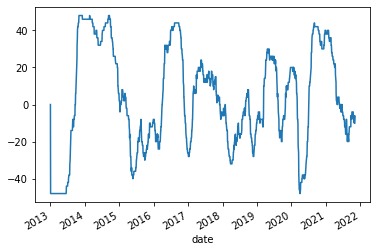

In [ ]:
solution.final.plot()

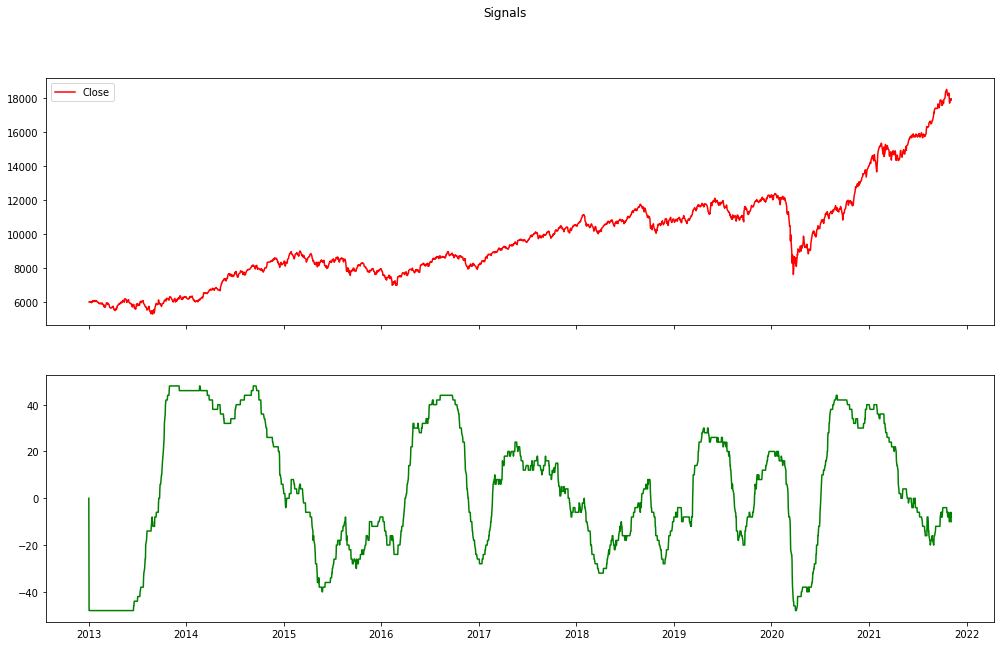

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(17,10),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
plt.show()